In [1]:
# Librearía de hugging face donde se encuentra el modelo preentrenado
!pip install -U sentence-transformers --quiet

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

In [3]:
# Otorgar acceso a drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
folder = '/content/drive/MyDrive/Manpower/Homologacion cargos/Production/data'

df_muestra = pd.read_excel(f"{folder}/Muestra.xlsx")
df_ocupaciones = pd.read_excel(f"{folder}/BaseCUOC.xlsx", sheet_name="Ocupacion")
df_descripciones = pd.read_excel(f"{folder}/BaseCUOC.xlsx", sheet_name="Descripcion")


In [5]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [6]:
# Codificar en embeddings todas las ocupaciones. Se concatena el título y la descripción y se halla el embedding
ocupaciones = list()
for i in range(len(df_ocupaciones)):
  # Las tablas de Nombre ocupacion y descripción están sincronizadas en el excel
  titulo = df_ocupaciones.loc[i, "Nombre Ocupación"]
  descripcion = df_descripciones.loc[i, "Descripción Ocupación"]
  concatenado = (titulo+". "+descripcion).lower()
  ocupaciones.append({
      "id" : df_ocupaciones.loc[i, "Ocupación"],
      "titulo" : titulo,
      "descripcion" : descripcion,
      "concatenado" : concatenado, 
      "procesado" : model.encode(concatenado)
  })

In [7]:
# Codificar en embeddings de los cargos de muestra. Se concatena el título y la descripción, y se halla el embedding
cargos = list()
for i in range(len(df_muestra)):
  titulo = df_muestra.loc[i,"Cargo"]
  descripcion = df_muestra.loc[i,"Descripción SP"]
  concatenado = (titulo+". " +descripcion).lower() 
  cargos.append({
          "titulo" : titulo,
          "descripcion" : descripcion,
          "concatenado" : concatenado,
          "procesado" : model.encode(concatenado),
          "homologacion_manual" : { "id": df_muestra.loc[i, "Codigo Cuoc"], "titulo": df_muestra.loc[i, "Ocupación"]}
      })

In [8]:

for cargo in cargos:
  cargo["similarities"] = list()
  for ocupacion in ocupaciones:
    cargo_vec = cargo["procesado"].reshape(1,-1)
    ocupacion_vec = ocupacion["procesado"].reshape(1,-1)
    sim = cosine_similarity(cargo_vec, ocupacion_vec)[0][0]
    cargo["similarities"].append((sim, ocupacion["id"], ocupacion["titulo"]))
  
  cargo["similarities"].sort(reverse=True)

In [9]:
resultados = list()
for cargo in cargos:
  more_similar_oc_id = cargo["similarities"][0][1]
  similarity = cargo["similarities"][0][0]

  if more_similar_oc_id == cargo["homologacion_manual"]["id"]:
    correcto = True
  else:
    correcto = False
  
  resultados.append((cargo["titulo"], cargo["descripcion"], more_similar_oc_id, similarity, correcto))

column_names = ["titulo_cargo", "descripcion_cargo", "ocupacion_mas_similar", "similitud", "es_correcto"]
resultados = pd.DataFrame(resultados, columns=column_names)

In [10]:
resultados

,titulo_cargo,descripcion_cargo,ocupacion_mas_similar,similitud,es_correcto
0,LINIERO MOVIL OMS EN ELECTRIFICADORA DEL HUILA...,Tecnico Electricista con experiencia en el are...,74112,0.559005,False
1,MERCAIMPULSADORA ALROVILLA Y COMPAÑIA S.A.S,"Ofrecer productos de consumo masivo, organizar...",33392,0.649341,False
2,OPERARIO DE MOLINOS SANTA MARTA,Se encargaran de apoyar las labores de cargue ...,93331,0.623415,True
3,OPERARIO PLANTA DE AGUAS EN DEXCO ZONA FRANCA SAS,Garantizar el flujo hídrico requerido por los ...,31213,0.581966,False
4,OPERARIO PRENSA LAMINACION EN DEXCO ZONA FRANC...,Laminar un tablero que cumpla con las especifi...,73212,0.667345,False
...,...,...,...,...,...
75,ANALISTA DE CARTERA EN SUNSTAR,"Conciliar cartera con los clientes, aplicar pa...",33133,0.719537,False
76,EJECUTIVO COMERCIAL ALIADO IT,"EJECUCIÓN Y CIERRE DE VENTA, AMPLIACION DE MER...",12220,0.526078,False
77,PROFESIONAL SEGURIDAD Y SALUD EN EL TRABAJO EN...,Velar por la seguridad y salud de todos los co...,22630,0.686429,True
78,MECANICO 1 EN ANTIOQUIA GOLD,"Reparación mecánica/eléctrica de simbas, jumbo...",72340,0.489544,False


In [11]:
len(resultados[resultados["es_correcto"]==True])

14

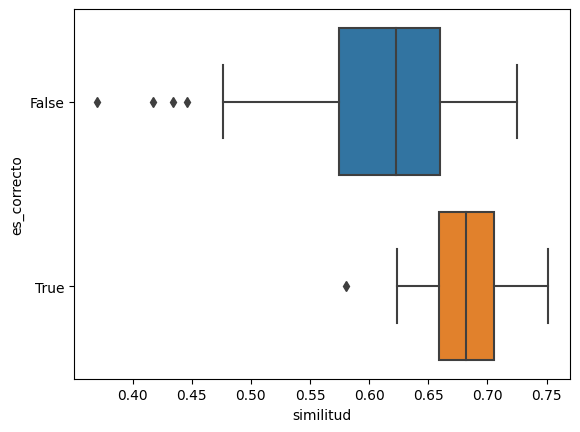

In [12]:
sns.boxplot(data = resultados, x="similitud", y="es_correcto", orient="h")
plt.show()

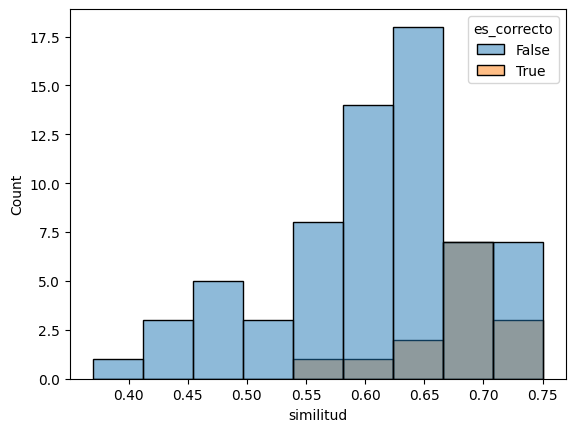

In [13]:
sns.histplot(data=resultados, x="similitud", hue="es_correcto" )
plt.show()

## Distancia euclidiana

In [14]:
for cargo in cargos:
  cargo["distances"] = list()
  for ocupacion in ocupaciones:
    dist = euclidean(cargo["procesado"], ocupacion["procesado"])
    cargo["distances"].append((dist, ocupacion["id"], ocupacion["titulo"]))
  
  cargo["distances"].sort()

In [15]:
resultados_euc = list()
for cargo in cargos:
  closer = cargo["distances"][0][1]
  distance = cargo["distances"][0][0]

  if closer == cargo["homologacion_manual"]["id"]:
    correcto = True
  else:
    correcto = False
  
  resultados_euc.append((cargo["titulo"], cargo["descripcion"], closer, distance, correcto))

column_names = ["titulo_cargo", "descripcion_cargo", "ocupacion_mas_cercana", "distancia", "es_correcto"]
resultados_euc = pd.DataFrame(resultados, columns=column_names)

In [16]:
resultados_euc

,titulo_cargo,descripcion_cargo,ocupacion_mas_cercana,distancia,es_correcto
2,OPERARIO DE MOLINOS SANTA MARTA,Se encargaran de apoyar las labores de cargue ...,NaN,NaN,True
9,TECNICO ELECTRONICO,"Responsable del mantenimiento, la resolución d...",NaN,NaN,True
14,AUXILIAR DE SALUD Y SEGURIDAD TRABAJO JNR EN Q...,Apoyar en todas las actividades planteadas par...,NaN,NaN,True
15,JEFE DE COMPRAS EN H UJUETA,Liderar proceso de compras en la compañia y ma...,NaN,NaN,True
21,AUXILIAR CONTABLE EN SPARCOL CHEMICALS & LIFE ...,"Manejo y apoyo en el áera de contabilidad, inv...",NaN,NaN,True
29,TENICO DE METROLOGIA EN COLCAFE,Verificar las condiciones de exactitud de los ...,NaN,NaN,True
42,ANALISTA DE SEGURIDAD Y SALUD EN SPARCOL CHEMICAL,Velar por la seguridad y salud de todos los co...,NaN,NaN,True
47,TECNÓLOGO EN SEGURIDAD Y SALUD EN EL TRABAJO E...,"Orientar, apoyar, gestionar y liderar acciones...",NaN,NaN,True
53,ASISTENTE ADMINISTRATIVO EN SERVICENTRO PROXXON,Brindar soporte operativo y asistir oportuname...,NaN,NaN,True
62,ASISTENTE ADMINISTRATIVA EN FRUBATEC,Brindar soporte operativo y asistir oportuname...,NaN,NaN,True


,titulo_cargo,descripcion_cargo,ocupacion_mas_cercana,distancia,es_correcto
2,OPERARIO DE MOLINOS SANTA MARTA,Se encargaran de apoyar las labores de cargue ...,NaN,NaN,True
9,TECNICO ELECTRONICO,"Responsable del mantenimiento, la resolución d...",NaN,NaN,True
14,AUXILIAR DE SALUD Y SEGURIDAD TRABAJO JNR EN Q...,Apoyar en todas las actividades planteadas par...,NaN,NaN,True
15,JEFE DE COMPRAS EN H UJUETA,Liderar proceso de compras en la compañia y ma...,NaN,NaN,True
21,AUXILIAR CONTABLE EN SPARCOL CHEMICALS & LIFE ...,"Manejo y apoyo en el áera de contabilidad, inv...",NaN,NaN,True
29,TENICO DE METROLOGIA EN COLCAFE,Verificar las condiciones de exactitud de los ...,NaN,NaN,True
42,ANALISTA DE SEGURIDAD Y SALUD EN SPARCOL CHEMICAL,Velar por la seguridad y salud de todos los co...,NaN,NaN,True
47,TECNÓLOGO EN SEGURIDAD Y SALUD EN EL TRABAJO E...,"Orientar, apoyar, gestionar y liderar acciones...",NaN,NaN,True
53,ASISTENTE ADMINISTRATIVO EN SERVICENTRO PROXXON,Brindar soporte operativo y asistir oportuname...,NaN,NaN,True
62,ASISTENTE ADMINISTRATIVA EN FRUBATEC,Brindar soporte operativo y asistir oportuname...,NaN,NaN,True
